In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor
import warnings

warnings.filterwarnings('ignore')

def run_analysis(data_filename, results_filename="results.pkl"):
    """
    Loads data from a CSV file, builds and samples a Bayesian hierarchical model using PyMC,
    computes the variance decomposition for the latent scale parameters, and saves key results to a file.
    
    Parameters:
      data_filename (str): Name of the CSV file containing the data.
      results_filename (str): Name of the file to save the results (default "results.pkl").
      
    The saved dictionary contains:
      - "trace": The InferenceData object from MCMC.
      - "variance_decomposition": A dictionary with keys 'total_variance', 'perc_c', 'perc_l', 'perc_p', 'perc_o'.
      - "effective_scales": A dictionary with keys 'S_est', 'LN_est', 'PN_est', 'ON_est'.
      - "data": The preprocessed pandas DataFrame.
    """
    
    # Set PyTensor flags before any PyTensor-related imports
    os.environ["PYTENSOR_DEVICE"] = "cpu"
    os.environ["PYTENSOR_FLOATX"] = "float64"
    os.environ["PYTENSOR_COMPUTE_TEST_VALUE"] = "ignore"
    
    print("Loading data from", data_filename)
    data = pd.read_csv(data_filename)
    print("Data head:")
    print(data.head())
    
    # Create integer indices.
    data['expert_idx'] = pd.Categorical(data['id']).codes
    data['case_idx'] = pd.Categorical(data['item']).codes
    data['occ_idx'] = pd.Categorical(data['t']).codes
    
    # Get dimensions.
    n_experts = data['expert_idx'].nunique()
    n_cases = data['case_idx'].nunique()
    n_obs = data.shape[0]
    
    print("\nDataset summary:")
    print(f"Number of experts: {n_experts}")
    print(f"Number of cases: {n_cases}")
    print(f"Number of observations: {n_obs}")
    
    # Build and sample from the PyMC model using non-centered parameterizations for all latent variables.
    print("\nBuilding model...")
    with pm.Model() as model:
        # Priors for scale parameters.
        sigma_c = pm.HalfNormal("sigma_c", sigma=1)
        sigma_l = pm.HalfNormal("sigma_l", sigma=1)
        sigma_p = pm.HalfNormal("sigma_p", sigma=1)
        sigma_o = pm.HalfNormal("sigma_o", sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        
        # Non-centered latent variables for cases, experts, and their interactions.
        z_c = pm.Normal("z_c", mu=0, sigma=1, shape=n_cases)
        c = pm.Deterministic("c", z_c * sigma_c)
        
        z_l = pm.Normal("z_l", mu=0, sigma=1, shape=n_experts)
        l = pm.Deterministic("l", z_l * sigma_l)
        
        z_p = pm.Normal("z_p", mu=0, sigma=1, shape=(n_experts, n_cases))
        p = pm.Deterministic("p", z_p * sigma_p)
        
        # Non-centered parameterization for observation-level effects.
        z_o = pm.Normal("z_o", mu=0, sigma=1, shape=n_obs)
        o = pm.Deterministic("o", z_o * sigma_o)
        
        # Linear predictor: use the indices as before.
        z = (intercept +
             c[data['case_idx'].values] +
             l[data['expert_idx'].values] +
             p[data['expert_idx'].values, data['case_idx'].values] +
             o)
        
        # Likelihood.
        y_obs = pm.Bernoulli("y_obs", logit_p=z, observed=data['Y'].values)
        
        # Setup monitoring for selected parameters.
        monitor_vars = ['sigma_c', 'sigma_l', 'sigma_p', 'sigma_o', 'intercept']
        diagnostics = None  # (Not using a live callback here.)
        
        print("\nSampling...")
        trace = pm.sample(
            draws=5000,
            tune=2000,
            chains=10,
            cores=6,
            random_seed=42,
            return_inferencedata=True,
            nuts_sampler='numpyro',
            init='jitter+adapt_diag',
            progressbar=True,
            target_accept=0.98
        )
    
    # Post-sampling analysis.
    print("\nPosterior Summary:")
    summary = az.summary(trace, var_names=monitor_vars)
    print(summary)
    
    # Extract posterior samples for the scale parameters (flattening across chains and draws)
    sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
    sigma_l_samples = trace.posterior['sigma_l'].values.flatten()
    sigma_p_samples = trace.posterior['sigma_p'].values.flatten()
    sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    
    # Compute the variance for each component (variance = sigma^2)
    var_c = np.mean(sigma_c_samples ** 2)
    var_l = np.mean(sigma_l_samples ** 2)
    var_p = np.mean(sigma_p_samples ** 2)
    var_o = np.mean(sigma_o_samples ** 2)
    
    # Calculate the total variance as the sum of the four component variances.
    total_variance = var_c + var_l + var_p + var_o
    
    # Compute percentage contributions based on variances.
    perc_c = (var_c / total_variance) * 100
    perc_l = (var_l / total_variance) * 100
    perc_p = (var_p / total_variance) * 100
    perc_o = (var_o / total_variance) * 100
    
    print("\nVariance Decomposition:")
    print(f"Total Variance (sum of components): {total_variance:.3f}")
    print("Percentage contributions:")
    print(f"  Signal (case) variance:         {perc_c:.2f}%")
    print(f"  Level noise (expert) variance:    {perc_l:.2f}%")
    print(f"  Pattern noise (interaction) variance: {perc_p:.2f}%")
    print(f"  Occasion noise (observation-level) variance: {perc_o:.2f}%")
    
    # Compute effective scale estimates as the square roots of the variances.
    S_est = np.sqrt(var_c)
    LN_est = np.sqrt(var_l)
    PN_est = np.sqrt(var_p)
    ON_est = np.sqrt(var_o)
    
    print("\nEffective scale estimates:")
    print(f"Signal (S): {S_est:.2f}")
    print(f"Level Noise (LN): {LN_est:.2f}")
    print(f"Pattern Noise (PN): {PN_est:.2f}")
    print(f"Occasion Noise (ON): {ON_est:.2f}")
    
    # Prepare results dictionary.
    results = {
        "trace": trace,
        "variance_decomposition": {
            "total_variance": total_variance,
            "perc_c": perc_c,
            "perc_l": perc_l,
            "perc_p": perc_p,
            "perc_o": perc_o
        },
        "effective_scales": {
            "S_est": S_est,
            "LN_est": LN_est,
            "PN_est": PN_est,
            "ON_est": ON_est
        },
        "data": data
    }
    
    # Save results to file.
    with open(results_filename, "wb") as f:
        pickle.dump(results, f)
    
    print(f"\nResults saved to {results_filename}")
    
    return results

# Call function
results1 = run_analysis("dataQ1.csv", "resultsQ1.pkl")
results3 = run_analysis("dataQ2.csv", "resultsQ2.pkl")
results2 = run_analysis("dataQEEG.csv", "resultsQEEG.pkl")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Loading data from dataQ1.csv
Data head:
   id  item  t  Y
0   1     1  1  0
1   1     2  1  0
2   1     3  1  0
3   1     4  1  0
4   1     5  1  1

Dataset summary:
Number of experts: 20
Number of cases: 50
Number of observations: 2000

Building model...

Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_c    3.119  0.397   2.410    3.888      0.004    0.003   12088.0   
sigma_l    1.830  0.332   1.246    2.461      0.003    0.002   15153.0   
sigma_p    1.182  0.278   0.662    1.706      0.003    0.002    6774.0   
sigma_o    0.372  0.281   0.000    0.877      0.004    0.003    5349.0   
intercept -4.792  0.741  -6.235   -3.454      0.009    0.007    6397.0   

           ess_tail  r_hat  
sigma_c     22541.0    1.0  
sigma_l     25200.0    1.0  
sigma_p      7196.0    1.0  
sigma_o      8618.0    1.0  
intercept   13498.0    1.0  

Variance Decomposition:
Total Variance (sum of components): 15.035
Percentage contributions:
  Signal (case) variance:         65.74%
  Level noise (expert) variance:    23.01%
  Pattern noise (interaction) variance: 9.81%
  Occasion noise (observation-level) variance: 1.44%

Effective scale estimates:
Signal (S): 3.14
Level Noise (LN): 1.86
Pattern Noise (P

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_c    3.303  0.363   2.646    3.994      0.003    0.002   11047.0   
sigma_l    0.899  0.203   0.547    1.290      0.002    0.001   16360.0   
sigma_p    1.935  0.217   1.515    2.329      0.002    0.002   10544.0   
sigma_o    0.366  0.278   0.000    0.864      0.005    0.003    3847.0   
intercept -0.148  0.531  -1.144    0.858      0.008    0.006    4399.0   

           ess_tail  r_hat  
sigma_c     19672.0    1.0  
sigma_l     28018.0    1.0  
sigma_p     18603.0    1.0  
sigma_o      5925.0    1.0  
intercept    9988.0    1.0  

Variance Decomposition:
Total Variance (sum of components): 15.890
Percentage contributions:
  Signal (case) variance:         69.48%
  Level noise (expert) variance:    5.34%
  Pattern noise (interaction) variance: 23.85%
  Occasion noise (observation-level) variance: 1.33%

Effective scale estimates:
Signal (S): 3.32
Level Noise (LN): 0.92
Pattern Noise (P

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]


Posterior Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_c    1.940  0.269   1.463    2.457      0.003    0.002    7146.0   
sigma_l    1.660  0.297   1.141    2.229      0.003    0.002   11757.0   
sigma_p    1.793  0.217   1.387    2.193      0.003    0.002    5369.0   
sigma_o    0.482  0.359   0.000    1.126      0.008    0.006    2275.0   
intercept  1.712  0.502   0.760    2.655      0.006    0.004    8087.0   

           ess_tail  r_hat  
sigma_c     11679.0    1.0  
sigma_l     22802.0    1.0  
sigma_p      8004.0    1.0  
sigma_o      3752.0    1.0  
intercept   13626.0    1.0  

Variance Decomposition:
Total Variance (sum of components): 10.303
Percentage contributions:
  Signal (case) variance:         37.22%
  Level noise (expert) variance:    27.59%
  Pattern noise (interaction) variance: 31.68%
  Occasion noise (observation-level) variance: 3.51%

Effective scale estimates:
Signal (S): 1.96
Level Noise (LN): 1.69
Pattern Noise (

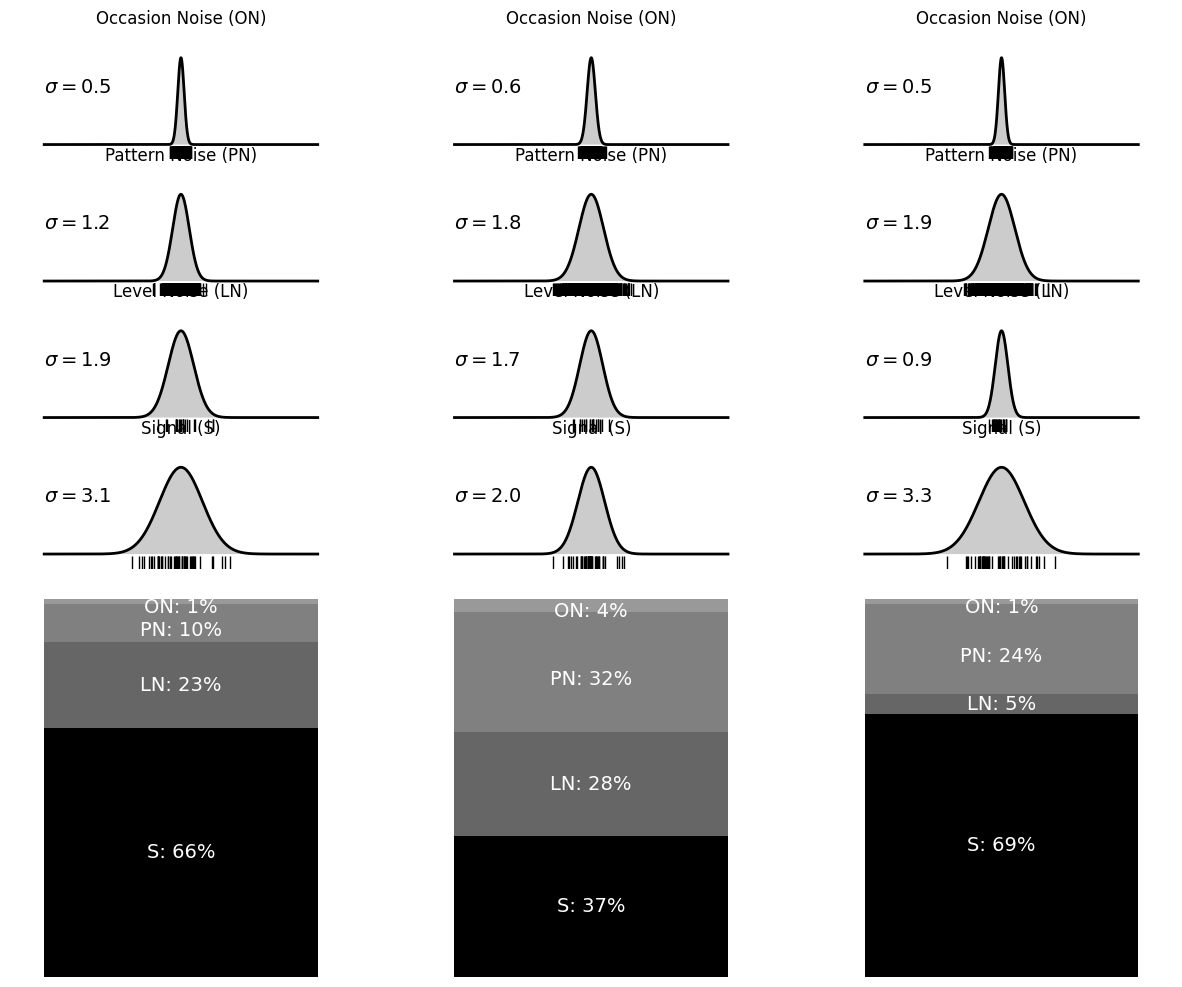

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st

#--------------------------------------------------
# Helper Function: fcn_gaussian_plot (mimicking MATLAB)
#--------------------------------------------------
def fcn_gaussian_plot(ax, x, s, titleStr):
    """
    Mimics the MATLAB fcnGaussianPlot.
    Fits a Gaussian to data x (using a fixed sigma value s),
    plots vertical tick marks at y=-0.1, fills under the normalized Gaussian density,
    overlays the fitted curve, and adds a text label showing the fitted sigma.
    All ticks and axes are removed.
    """
    # Generate x values for plotting the fitted curve.
    xx = np.linspace(-20, 20, 1000)
    y = st.norm.pdf(xx, loc=0, scale=s)
    y = y / np.max(y)  # Normalize so that max(y)==1.
    
    # Plot vertical tick marks at each data point at y = -0.1.
    ax.plot(x, np.full_like(x, -0.1), 'k|', markersize=10)
    
    # Fill the area under the fitted curve.
    ax.fill_between(xx, 0, y, color=[0.8, 0.8, 0.8], edgecolor='none')
    # Plot the fitted Gaussian curve.
    ax.plot(xx, y, 'k', linewidth=2)
    
    # Add text showing the fitted sigma.
    ax.text(-20, 0.6, f"$\\sigma = {s:.1f}$", fontsize=14)
    
    # Remove ticks and axis labels.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_title(titleStr)
    ax.set_xlim([-25, 25])

#--------------------------------------------------
# Helper Function: fcn_plot_stacked_bars_percent (vertical version using variance percentages)
#--------------------------------------------------
def fcn_plot_stacked_bars_percent(ax, perc_array, labels=None, on_offset=1):
    """
    Plots a vertical stacked bar using the given percentages.
    The input perc_array should be an array of percentages (e.g. [perc_c, perc_l, perc_p, perc_o])
    that sum to 100. The labels (if not provided) default to:
         ['S', 'LN', 'PN', 'ON'].
    Text labels are placed at the midpoint of each segment computed from the cumulative sum.
    For the top segment (Occasion Noise), the text is shifted downward by 'on_offset' units
    to ensure it is fully visible.
    """
    if labels is None:
        labels = ['S', 'LN', 'PN', 'ON']
    
    # Define colors (similar to MATLAB's cc matrix).
    cc = np.array([[0, 0, 0],
                   [0.4, 0.4, 0.4],
                   [0.5, 0.5, 0.5],
                   [0.6, 0.6, 0.6]])
    
    # Compute cumulative sums of percentages.
    cumsum_vals = np.cumsum(perc_array)
    prev = 0
    for i, val in enumerate(perc_array):
        # Compute the midpoint of the segment.
        mid = (prev + cumsum_vals[i]) / 2
        # For the top segment (last one: ON), shift the text down by on_offset units.
        if i == len(perc_array) - 1:
            mid = mid - 1.5
        if i == len(perc_array) - 2:
            mid = mid - 2
        ax.bar(0, val, bottom=prev, color=cc[i], width=0.8, edgecolor='none')
        ax.text(0, mid, f"{labels[i]}: {val:.0f}%", ha='center', va='center', color='white', fontsize=14)
        prev = cumsum_vals[i]
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

#--------------------------------------------------
# Plotting for all three sets of results
#--------------------------------------------------

# List of your results dictionaries and titles for each column
results_list = [results1, results2, results3]
titles = ["", "", ""]

# Create the overall figure. Adjust the figsize if needed.
fig = plt.figure(figsize=(15, 12))
# Create a 7 (rows) x 3 (columns) grid.
gs = gridspec.GridSpec(7, 3, figure=fig, hspace=0.3)

# Loop over each results set to plot in its respective column.
for col, (res, col_title) in enumerate(zip(results_list, titles)):
    # Extract the trace from the results dictionary.
    trace = res["trace"]
    
    # Extract posterior samples for the scale parameters.
    sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
    sigma_l_samples = trace.posterior['sigma_l'].values.flatten()
    sigma_p_samples = trace.posterior['sigma_p'].values.flatten()
    sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    
    # Compute the variance for each component (variance = sigma^2)
    var_c = np.mean(sigma_c_samples ** 2)
    var_l = np.mean(sigma_l_samples ** 2)
    var_p = np.mean(sigma_p_samples ** 2)
    var_o = np.mean(sigma_o_samples ** 2)
    
    # Calculate the total variance as the sum of the four component variances.
    total_variance = var_c + var_l + var_p + var_o
    
    # Compute percentage contributions.
    perc_c = (var_c / total_variance) * 100
    perc_l = (var_l / total_variance) * 100
    perc_p = (var_p / total_variance) * 100
    perc_o = (var_o / total_variance) * 100
    
    # Compute effective scale estimates (square roots of the variances).
    S_est = np.sqrt(var_c)
    LN_est = np.sqrt(var_l)
    PN_est = np.sqrt(var_p)
    ON_est = np.sqrt(var_o)
    
    # ----------------------------
    # Gaussian plot for Occasion Noise (ON)
    # ----------------------------
    ax1 = fig.add_subplot(gs[0, col])
    x_on = np.random.randn(50 * 20) * ON_est
    fcn_gaussian_plot(ax1, x_on, ON_est, f"Occasion Noise (ON)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Pattern Noise (PN)
    # ----------------------------
    ax2 = fig.add_subplot(gs[1, col])
    x_pn = np.random.randn(20 * 50) * PN_est
    fcn_gaussian_plot(ax2, x_pn, PN_est, f"Pattern Noise (PN)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Level Noise (LN)
    # ----------------------------
    ax3 = fig.add_subplot(gs[2, col])
    x_ln = np.random.randn(20) * LN_est
    fcn_gaussian_plot(ax3, x_ln, LN_est, f"Level Noise (LN)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Signal (S)
    # ----------------------------
    ax4 = fig.add_subplot(gs[3, col])
    x_s = np.random.randn(50) * S_est
    fcn_gaussian_plot(ax4, x_s, S_est, f"Signal (S)\n{col_title}")
    
    # ----------------------------
    # Vertical Stacked Bar Plot (variance percentages)
    # ----------------------------
    ax5 = fig.add_subplot(gs[4:, col])
    perc_array = [perc_c, perc_l, perc_p, perc_o]
    fcn_plot_stacked_bars_percent(ax5, perc_array)

# plt.tight_layout()
# plt.show()


# Adjust layout for clarity.
plt.tight_layout()

# Save the figure as a publication-ready PNG file.
plt.savefig("publication_plot.png", dpi=300, bbox_inches='tight')

# Optionally display the figure.
plt.show()


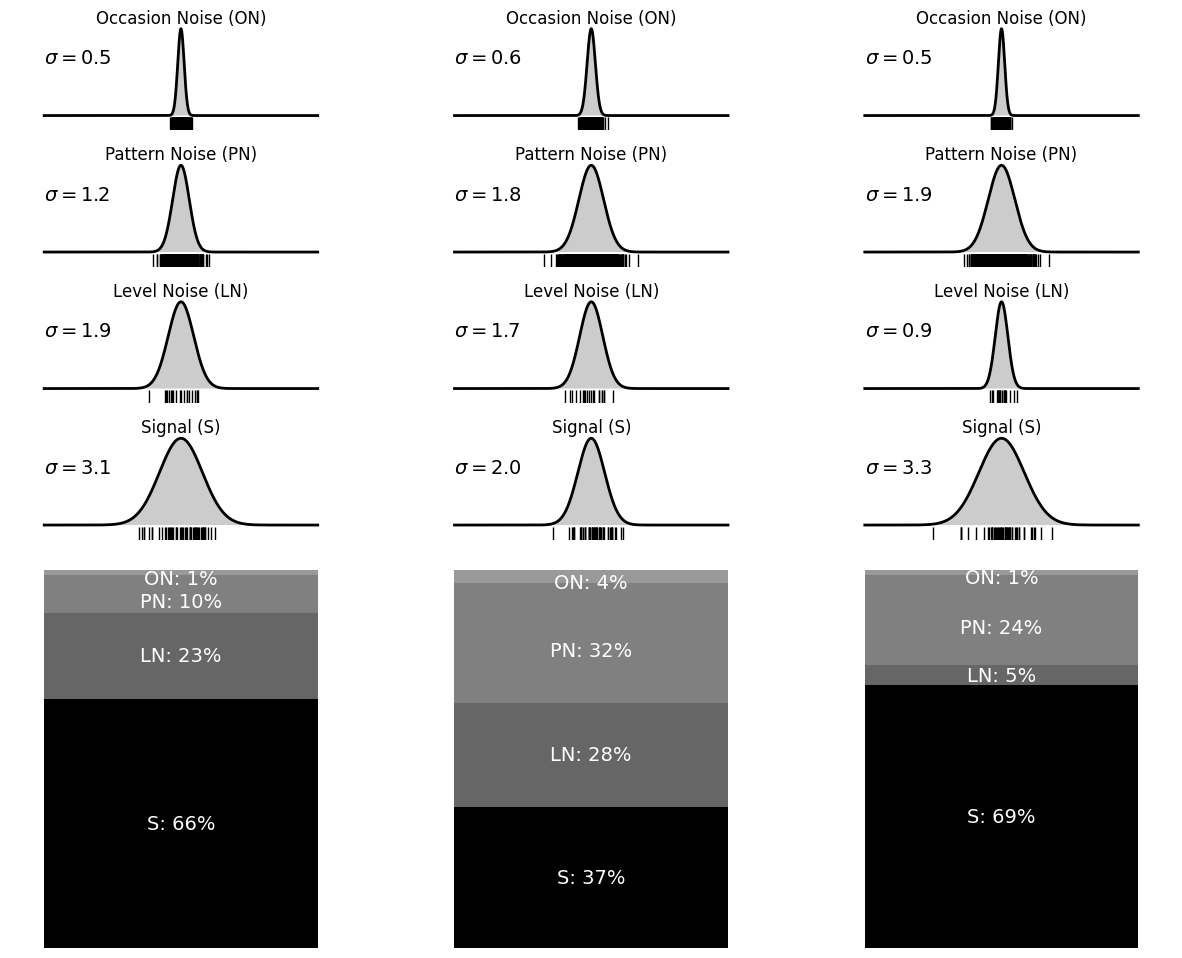

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as st

#--------------------------------------------------
# Helper Function: fcn_gaussian_plot (mimicking MATLAB)
#--------------------------------------------------
def fcn_gaussian_plot(ax, x, s, titleStr):
    """
    Mimics the MATLAB fcnGaussianPlot.
    Fits a Gaussian to data x (using a fixed sigma value s),
    plots vertical tick marks at y=-0.1, fills under the normalized Gaussian density,
    overlays the fitted curve, and adds a text label showing the fitted sigma.
    All ticks and axes are removed.
    """
    # Generate x values for plotting the fitted curve.
    xx = np.linspace(-20, 20, 1000)
    y = st.norm.pdf(xx, loc=0, scale=s)
    y = y / np.max(y)  # Normalize so that max(y)==1.
    
    # Plot vertical tick marks at each data point at y = -0.1.
    ax.plot(x, np.full_like(x, -0.1), 'k|', markersize=10)
    
    # Fill the area under the fitted curve.
    ax.fill_between(xx, 0, y, color=[0.8, 0.8, 0.8], edgecolor='none')
    # Plot the fitted Gaussian curve.
    ax.plot(xx, y, 'k', linewidth=2)
    
    # Add text showing the fitted sigma.
    ax.text(-20, 0.6, f"$\\sigma = {s:.1f}$", fontsize=14)
    
    # Remove ticks and axis labels.
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    # Adjust the title placement with extra padding (adjust pad value as needed)
    # ax.set_title(titleStr, pad=20)
    ax.set_title(titleStr, y=0.73)
    ax.set_xlim([-25, 25])

#--------------------------------------------------
# Helper Function: fcn_plot_stacked_bars_percent (vertical version using variance percentages)
#--------------------------------------------------
def fcn_plot_stacked_bars_percent(ax, perc_array, labels=None, on_offset=1):
    """
    Plots a vertical stacked bar using the given percentages.
    The input perc_array should be an array of percentages (e.g. [perc_c, perc_l, perc_p, perc_o])
    that sum to 100. The labels (if not provided) default to:
         ['S', 'LN', 'PN', 'ON'].
    Text labels are placed at the midpoint of each segment computed from the cumulative sum.
    For the top segment (Occasion Noise), the text is shifted downward by 'on_offset' units
    to ensure it is fully visible.
    """
    if labels is None:
        labels = ['S', 'LN', 'PN', 'ON']
    
    # Define colors (similar to MATLAB's cc matrix).
    cc = np.array([[0, 0, 0],
                   [0.4, 0.4, 0.4],
                   [0.5, 0.5, 0.5],
                   [0.6, 0.6, 0.6]])
    
    # Compute cumulative sums of percentages.
    cumsum_vals = np.cumsum(perc_array)
    prev = 0
    for i, val in enumerate(perc_array):
        # Compute the midpoint of the segment.
        mid = (prev + cumsum_vals[i]) / 2
        # For the top segment (last one: ON), shift the text down by on_offset units.
        if i == len(perc_array) - 1:
            mid = mid - 1.5
        if i == len(perc_array) - 2:
            mid = mid - 2
        ax.bar(0, val, bottom=prev, color=cc[i], width=0.8, edgecolor='none')
        ax.text(0, mid, f"{labels[i]}: {val:.0f}%", ha='center', va='center', color='white', fontsize=14)
        prev = cumsum_vals[i]
    
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

#--------------------------------------------------
# Plotting for all three sets of results
#--------------------------------------------------

# List of your results dictionaries and titles for each column
results_list = [results1, results2, results3]
titles = ["", "", ""]

# Create the overall figure. Adjust the figsize if needed.
fig = plt.figure(figsize=(15, 12))
# Create a 7 (rows) x 3 (columns) grid.
gs = gridspec.GridSpec(7, 3, figure=fig, hspace=0.3)

# Loop over each results set to plot in its respective column.
for col, (res, col_title) in enumerate(zip(results_list, titles)):
    # Extract the trace from the results dictionary.
    trace = res["trace"]
    
    # Extract posterior samples for the scale parameters.
    sigma_c_samples = trace.posterior['sigma_c'].values.flatten()
    sigma_l_samples = trace.posterior['sigma_l'].values.flatten()
    sigma_p_samples = trace.posterior['sigma_p'].values.flatten()
    sigma_o_samples = trace.posterior['sigma_o'].values.flatten()
    
    # Compute the variance for each component (variance = sigma^2)
    var_c = np.mean(sigma_c_samples ** 2)
    var_l = np.mean(sigma_l_samples ** 2)
    var_p = np.mean(sigma_p_samples ** 2)
    var_o = np.mean(sigma_o_samples ** 2)
    
    # Calculate the total variance as the sum of the four component variances.
    total_variance = var_c + var_l + var_p + var_o
    
    # Compute percentage contributions.
    perc_c = (var_c / total_variance) * 100
    perc_l = (var_l / total_variance) * 100
    perc_p = (var_p / total_variance) * 100
    perc_o = (var_o / total_variance) * 100
    
    # Compute effective scale estimates (square roots of the variances).
    S_est = np.sqrt(var_c)
    LN_est = np.sqrt(var_l)
    PN_est = np.sqrt(var_p)
    ON_est = np.sqrt(var_o)
    
    # ----------------------------
    # Gaussian plot for Occasion Noise (ON)
    # ----------------------------
    ax1 = fig.add_subplot(gs[0, col])
    x_on = np.random.randn(50 * 20) * ON_est
    fcn_gaussian_plot(ax1, x_on, ON_est, f"Occasion Noise (ON)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Pattern Noise (PN)
    # ----------------------------
    ax2 = fig.add_subplot(gs[1, col])
    x_pn = np.random.randn(20 * 50) * PN_est
    fcn_gaussian_plot(ax2, x_pn, PN_est, f"Pattern Noise (PN)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Level Noise (LN)
    # ----------------------------
    ax3 = fig.add_subplot(gs[2, col])
    x_ln = np.random.randn(20) * LN_est
    fcn_gaussian_plot(ax3, x_ln, LN_est, f"Level Noise (LN)\n{col_title}")
    
    # ----------------------------
    # Gaussian plot for Signal (S)
    # ----------------------------
    ax4 = fig.add_subplot(gs[3, col])
    x_s = np.random.randn(50) * S_est
    fcn_gaussian_plot(ax4, x_s, S_est, f"Signal (S)\n{col_title}")
    
    # ----------------------------
    # Vertical Stacked Bar Plot (variance percentages)
    # ----------------------------
    ax5 = fig.add_subplot(gs[4:, col])
    perc_array = [perc_c, perc_l, perc_p, perc_o]
    fcn_plot_stacked_bars_percent(ax5, perc_array)

# Adjust layout for clarity.
plt.tight_layout()

# Save the figure as a publication-ready PNG file.
plt.savefig("publication_plot.png", dpi=300, bbox_inches='tight')

# Optionally display the figure.
plt.show()
